In [1]:
!pip install -q lightgbm catboost xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.8 MB/s eta 0:00:00


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker
from catboost import CatBoostRanker, Pool
from xgboost import XGBRanker

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
# Create a toy ranking dataset
ranking_data = pd.DataFrame({
    'query': np.random.randint(1, 6, 1000),
    'feature1': np.random.random(1000),
    'feature2': np.random.random(1000),
    'feature3': np.random.random(1000),
    'target': np.random.randint(0, 2, 1000)
})

In [7]:
X_rank = ranking_data[['feature1', 'feature2', 'feature3']]
y_rank = ranking_data['target']
group = ranking_data['query'].values

In [16]:
# Split into training and test sets
X_train_rank, X_test_rank, y_train_rank, y_test_rank, group_train, group_test = train_test_split(
    X_rank, y_rank, group, test_size=0.2, random_state=42)

In [20]:
# Ranking Models
ranking_models = {
    "LightGBM Ranker": LGBMRanker(random_state=42),
    "CatBoost Ranker": CatBoostRanker(verbose=0, random_state=42),
    "XGBoost Ranker": XGBRanker(objective='rank:pairwise', random_state=42)
}

# Train and Evaluate Models
for name, model in ranking_models.items():
    print(f"Training {name}...")
    if name == "CatBoost Ranker":
        sorted_indices = np.argsort(group_train)
        X_train_rank_sorted = X_train_rank.iloc[sorted_indices]
        y_train_rank_sorted = y_train_rank.iloc[sorted_indices]
        group_train_sorted = group_train[sorted_indices]

        train_pool = Pool(data=X_train_rank_sorted, label=y_train_rank_sorted, group_id=group_train_sorted)  # Create Pool object for CatBoost
        model.fit(train_pool)  # Use Pool object for fitting CatBoost
    else:
        query_sizes_train = X_train_rank.groupby(group_train).size().to_numpy()
        model.fit(X_train_rank, y_train_rank, group=query_sizes_train)

    y_pred_rank = model.predict(X_test_rank)
    print(f"{name} predictions (first 10): {y_pred_rank[:10]}")

Training LightGBM Ranker...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Ranker predictions (first 10): [ 0.66761367 -5.0478534  -8.49527476 -2.26544772  2.95537709  2.80817572
  0.08923024  1.3811656  -4.31198124  4.41268456]
Training CatBoost Ranker...
CatBoost Ranker predictions (first 10): [ 1.11936091 -0.47969013 -1.73679681  0.00471805  0.14530912  2.34666283
  1.17940944 -0.14425777  3.25741007  1.54075343]
Training XGBoost Ranker...
XGBoos

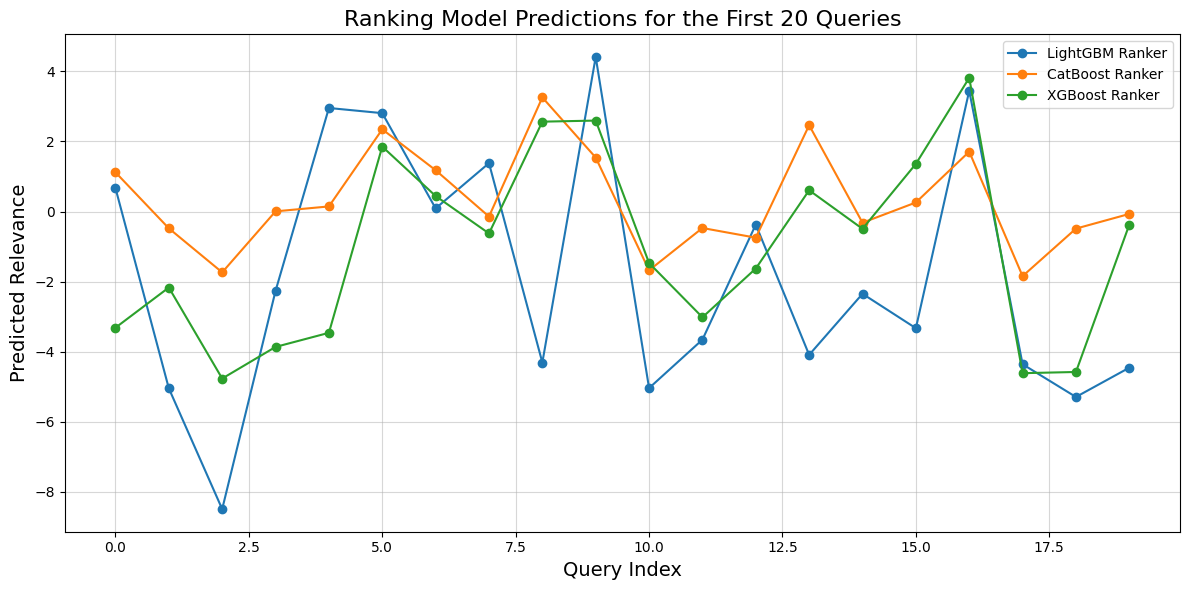

In [21]:
# Visualize predictions from ranking models for the first 20 queries
plt.figure(figsize=(12, 6))
for name, model in ranking_models.items():
    y_pred_rank = model.predict(X_test_rank)
    plt.plot(range(20), y_pred_rank[:20], marker='o', label=name)

plt.title('Ranking Model Predictions for the First 20 Queries', fontsize=16)
plt.xlabel('Query Index', fontsize=14)
plt.ylabel('Predicted Relevance', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()